# 🧠 Projeto de Previsão de Rotatividade de Clientes

## 📍 Visão Geral

A **Interconnect**, uma operadora de comunicações, deseja reduzir a rotatividade de seus clientes por meio de um sistema preditivo capaz de identificar usuários propensos ao cancelamento de contrato. A detecção antecipada desses clientes permitirá que a empresa ofereça promoções, upgrades e condições especiais de retenção.

Este projeto de ciência de dados tem como finalidade construir um modelo de classificação binária que identifique, com alta performance, se um cliente está inclinado a abandonar a operadora com base em seu perfil, tipo de contrato e serviços utilizados.

---

## 🎯 Objetivos

- 🔍 Realizar uma análise criteriosa dos dados fornecidos pela Interconnect.
- 🧹 Aplicar boas práticas de pré-processamento e engenharia de features.
- ⚙️ Construir pipelines de dados para garantir reprodutibilidade e modularidade.
- 🤖 Treinar e comparar modelos preditivos com foco em performance e interpretabilidade.
- 📈 Otimizar a métrica primária **AUC-ROC**, buscando um valor igual ou superior a **0.88**.
- 🧾 Documentar cada etapa com clareza, rigor técnico e foco em aplicabilidade real.

---

## 🧰 Fontes de Dados

Serão utilizados quatro conjuntos de dados fornecidos pela empresa:

| Arquivo         | Descrição                                    |
|------------------|----------------------------------------------|
| `contract.csv`   | Informações contratuais dos clientes         |
| `personal.csv`   | Dados pessoais e demográficos dos clientes   |
| `internet.csv`   | Uso e tipo de conexão com a internet         |
| `phone.csv`      | Serviços de telefonia contratados            |

---

## 📌 Característica-Alvo

A variável alvo (`target`) será derivada da coluna `EndDate`. Clientes com `EndDate = 'No'` serão considerados **ativos** (não cancelaram), enquanto os demais serão rotulados como **cancelados**.

---

## 📊 Métricas de Avaliação

- **Principal**: AUC-ROC (quanto mais próximo de 1, melhor)
- **Secundária**: Acurácia

---

## ✅ Critérios de Sucesso

| AUC-ROC             | Desempenho Esperado |
|---------------------|---------------------|
| < 0.75              | Insatisfatório      |
| 0.75 – 0.81         | Regular             |
| 0.81 – 0.85         | Bom                 |
| 0.85 – 0.87         | Muito bom           |
| 0.87 – 0.88         | Excelente           |
| ≥ 0.88              | **Ótimo (meta alvo)** |

---

## 🧭 Abordagem Metodológica

Este projeto será conduzido em etapas progressivas e bem documentadas:

1. **Configuração e estruturação do ambiente**
2. **Carregamento e unificação dos dados**
3. **Análise exploratória (EDA)**
4. **Pré-processamento e engenharia de features**
5. **Construção de pipelines**
6. **Treinamento e avaliação de modelos**
7. **Análise de desempenho e explicabilidade**
8. **Exportação e entrega final do modelo**

---

## 📅 Início do Projeto

**15 de Junho de 2025**

---

**Autor:** Lucas Coelho  
**Função:** Data Scientist  
**Contato:** lukaslopes.coelho@icloud.com

---


In [55]:
%pip install mlflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [56]:
# ================================
# 📦 IMPORTAÇÃO DE BIBLIOTECAS
# ================================

# Instalar shap se necessário
%pip install shap

# Manipulação e análise de dados
import pandas as pd
import numpy as np

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Pré-processamento
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Modelagem
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Avaliação de modelos
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    RocCurveDisplay
)

# Utilidades
import warnings
import os

# Ignore warnings
warnings.filterwarnings('ignore')

# Configurações de exibição
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')
import mlflow 


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [57]:
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment(experiment_id="590456896953749817")

<Experiment: artifact_location='mlflow-artifacts:/590456896953749817', creation_time=1751293906024, experiment_id='590456896953749817', last_update_time=1751293906024, lifecycle_stage='active', name='chrun-api', tags={}>

In [58]:
df_contract = pd.read_csv('data/contract.csv')
df_internet = pd.read_csv('data/internet.csv')
df_phone = pd.read_csv('data/phone.csv')
df_personal = pd.read_csv('data/personal.csv')

# 🔍 Etapa 2 — Análise Exploratória dos Dados (EDA)

## 🎯 Objetivo

Antes de construir qualquer modelo, é essencial entender profundamente os dados disponíveis. A análise exploratória (EDA) nos ajudará a:

- Compreender a estrutura e qualidade dos dados.
- Identificar padrões, outliers e inconsistências.
- Avaliar a distribuição de variáveis numéricas e categóricas.
- Explorar relações entre variáveis e a variável alvo (`EndDate`).
- Guiar a criação de features relevantes para a modelagem.

---

## 📂 Conjuntos de Dados

Os arquivos carregados foram:

- `df_contract`: informações sobre contratos (tipo, duração, forma de pagamento e status do cliente).
- `df_internet`: serviços relacionados à internet e adicionais.
- `df_phone`: serviços telefônicos contratados.
- `df_personal`: dados demográficos e pessoais dos clientes.

Cada DataFrame possui uma chave em comum: `customerID`, que será usada posteriormente para unir os dados em uma base única de análise.

---

## 🧪 Próximas Ações

A análise exploratória será dividida em etapas:

1. **Visualização de amostras iniciais** com `.head()` e `.info()`.
2. **Análise de valores nulos e duplicados**.
3. **Verificação e tratamento de tipos de dados**.
4. **Distribuição de variáveis importantes**.
5. **Exploração da variável alvo (`EndDate`) e criação da variável binária de churn.**
6. **Análise cruzada entre serviços, perfil e churn.**

Todas as análises serão acompanhadas de visualizações claras com `seaborn` e `matplotlib`, além de comentários explicativos para guiar as decisões posteriores.

---



In [59]:
# ==========================================
# 🔍 Análise Exploratória: Visão Geral
# ==========================================

# Função auxiliar para resumir o DataFrame
def resumo_df(df, nome):
    print(f"\n📘 Estrutura do DataFrame: {nome}")
    print("-" * 50)
    print(df.info())
    print("\n🧾 Amostra dos dados:")
    display(df.head())
    print("\n🔍 Valores ausentes por coluna:")
    display(df.isnull().sum())
    print("=" * 50)

# Resumo de todos os conjuntos
resumo_df(df_contract, "Contrato")
resumo_df(df_personal, "Pessoal")
resumo_df(df_internet, "Internet")
resumo_df(df_phone, "Telefone")



📘 Estrutura do DataFrame: Contrato
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

🧾 Amostra dos dados:


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65



🔍 Valores ausentes por coluna:


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


📘 Estrutura do DataFrame: Pessoal
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

🧾 Amostra dos dados:


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No



🔍 Valores ausentes por coluna:


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


📘 Estrutura do DataFrame: Internet
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

🧾 Amostra dos dados:


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No



🔍 Valores ausentes por coluna:


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


📘 Estrutura do DataFrame: Telefone
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

🧾 Amostra dos dados:


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes



🔍 Valores ausentes por coluna:


customerID       0
MultipleLines    0
dtype: int64

# 📊 Etapa 2 — Análise Exploratória (Parte 1): Visão Geral dos Dados

## ✅ 2.1 Estrutura Inicial dos DataFrames

Após a leitura completa dos dados, os quatro DataFrames analisados foram:

---

### 🟦 `df_contract` — Informações Contratuais

| Coluna             | Tipo    | Observações                     |
|---------------------|---------|----------------------------------|
| `BeginDate`         | object  | Data de início do contrato       |
| `EndDate`           | object  | Usado para gerar o label `churn` |
| `Type`              | object  | Duração do contrato              |
| `PaymentMethod`     | object  | Diversos métodos possíveis       |
| `MonthlyCharges`    | float64 | Valor mensal                    |
| `TotalCharges`      | object  | *Possivelmente mal tipado*       |

🔎 **Atenção:** a coluna `TotalCharges` está como `object`, mesmo sendo numérica. Provavelmente contém strings inválidas ou espaços em branco — isso será tratado no pré-processamento.

---

### 🟩 `df_personal` — Dados Pessoais

| Coluna         | Tipo     | Observações                   |
|----------------|----------|-------------------------------|
| `SeniorCitizen`| int64    | 0 = Não idoso, 1 = Idoso      |
| `Partner`      | object   | Cliente tem cônjuge?          |
| `Dependents`   | object   | Cliente tem dependentes?      |

📌 Nenhum valor nulo encontrado. Estrutura limpa e clara.

---

### 🟨 `df_internet` — Serviços de Internet

| Coluna             | Tipo     | Observações                                |
|--------------------|----------|---------------------------------------------|
| `InternetService`  | object   | DSL, Fiber optic ou No                      |
| Serviços adicionais| object   | OnlineSecurity, TechSupport, Streaming etc. |

🎯 Todos os dados estão completos. Variáveis categóricas binárias do tipo Yes/No.

---

### 🟥 `df_phone` — Serviços de Telefonia

| Coluna           | Tipo   | Observações                     |
|------------------|--------|----------------------------------|
| `MultipleLines`  | object | Cliente usa mais de uma linha?   |

📉 Esse DataFrame tem menos registros (6361 vs 7043), ou seja, **nem todos os clientes têm telefonia** — atenção ao fazer merge posterior.

---

## 🚨 Considerações Técnicas

- ✅ **Nenhum valor nulo** encontrado em nenhuma das tabelas.
- ⚠️ `TotalCharges` precisa ser convertida para numérico após limpeza.
- 📌 Será necessário tratar os tipos de dados antes de modelagem.
- 🧩 Os dados estão prontos para unificação com base em `customerID`.

---

## ⏭️ Próximos Passos

1. Criar a variável **`churn`** com base em `EndDate` (valor `No` indica cliente ativo).
2. Unificar todos os DataFrames em uma **base analítica única**.
3. Iniciar análise das distribuições, correlações e segmentações.

---


In [60]:
# ============================
# 🎯 Criar variável 'churn'
# ============================
df_contract['churn'] = df_contract['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

# ============================
# 🔗 Merge dos DataFrames
# ============================

# Unir com dados pessoais (todos têm)
df_merged = df_contract.merge(df_personal, on='customerID', how='left')

# Unir com dados de internet (alguns podem não ter)
df_merged = df_merged.merge(df_internet, on='customerID', how='left')

# Unir com dados de telefonia (alguns podem não ter)
df_merged = df_merged.merge(df_phone, on='customerID', how='left')

print(f"✅ Base unificada criada com shape: {df_merged.shape}")


✅ Base unificada criada com shape: (7043, 21)


In [61]:
# Substituir espaços por NaN e converter para float
df_merged['TotalCharges'] = pd.to_numeric(df_merged['TotalCharges'].replace(" ", np.nan), errors='coerce')


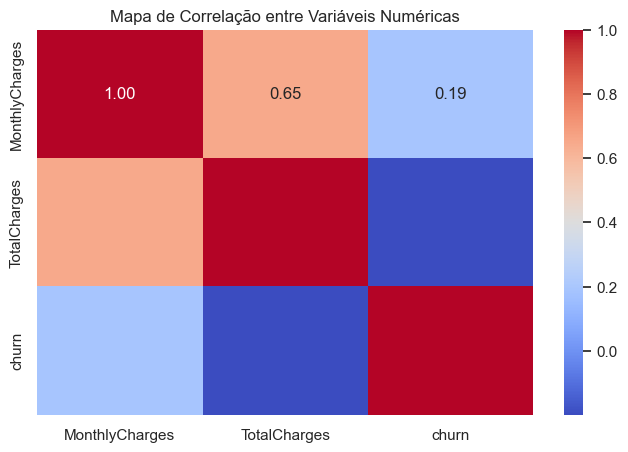

In [62]:
# ============================
# 🔥 Heatmap de correlação
# ============================

# Selecionar apenas colunas numéricas para correlação
df_corr = df_merged[['MonthlyCharges', 'TotalCharges', 'churn']].copy()
plt.figure(figsize=(8, 5))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de Correlação entre Variáveis Numéricas")
plt.show()


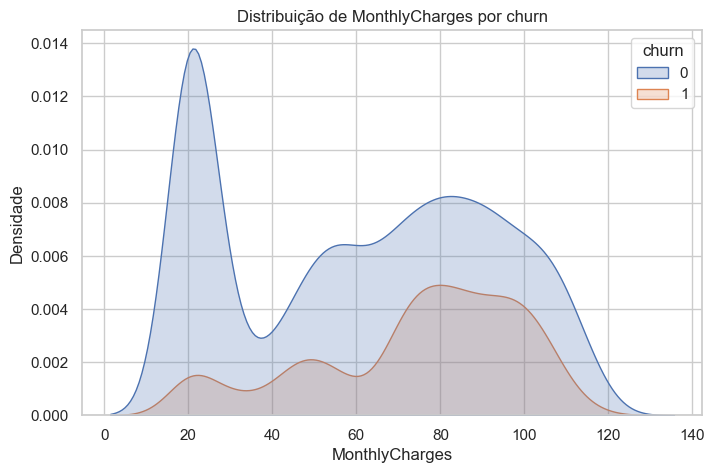

In [63]:
# ============================
# 📈 Distribuição: MonthlyCharges
# ============================

plt.figure(figsize=(8, 5))
sns.kdeplot(data=df_merged, x='MonthlyCharges', hue='churn', fill=True)
plt.title("Distribuição de MonthlyCharges por churn")
plt.xlabel("MonthlyCharges")
plt.ylabel("Densidade")
plt.show()


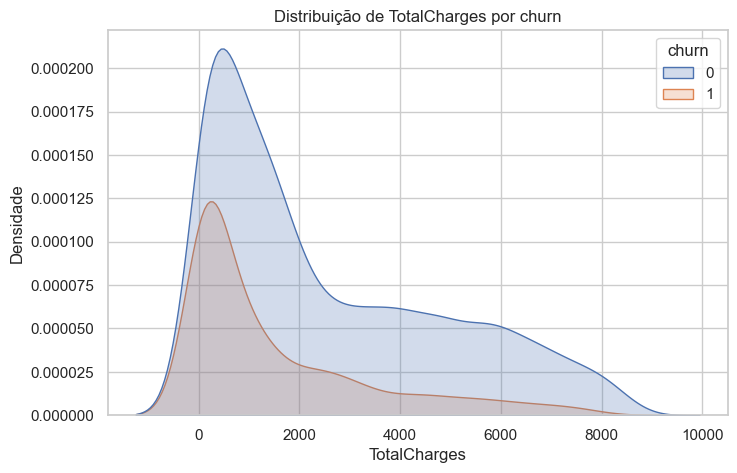

In [64]:
# ============================
# 📊 Distribuição: TotalCharges
# ============================

plt.figure(figsize=(8, 5))
sns.kdeplot(data=df_merged, x='TotalCharges', hue='churn', fill=True)
plt.title("Distribuição de TotalCharges por churn")
plt.xlabel("TotalCharges")
plt.ylabel("Densidade")
plt.show()


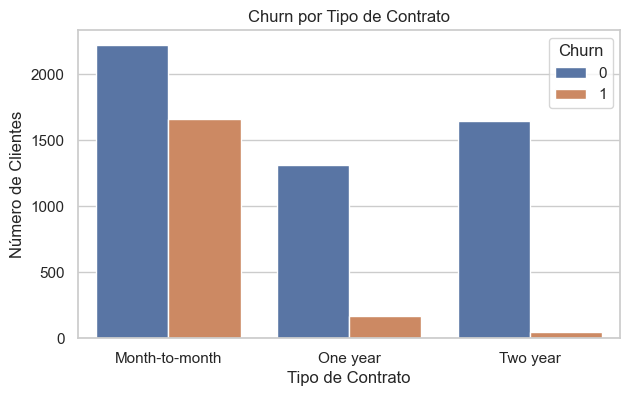

In [65]:
plt.figure(figsize=(7, 4))
sns.countplot(data=df_merged, x='Type', hue='churn')
plt.title("Churn por Tipo de Contrato")
plt.xlabel("Tipo de Contrato")
plt.ylabel("Número de Clientes")
plt.legend(title='Churn')
plt.xticks(rotation=0)
plt.show()


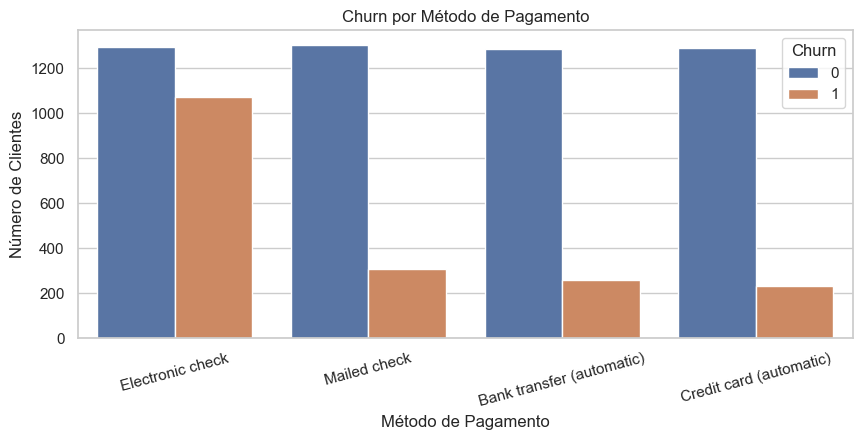

In [66]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df_merged, x='PaymentMethod', hue='churn')
plt.title("Churn por Método de Pagamento")
plt.xlabel("Método de Pagamento")
plt.ylabel("Número de Clientes")
plt.legend(title='Churn')
plt.xticks(rotation=15)
plt.show()


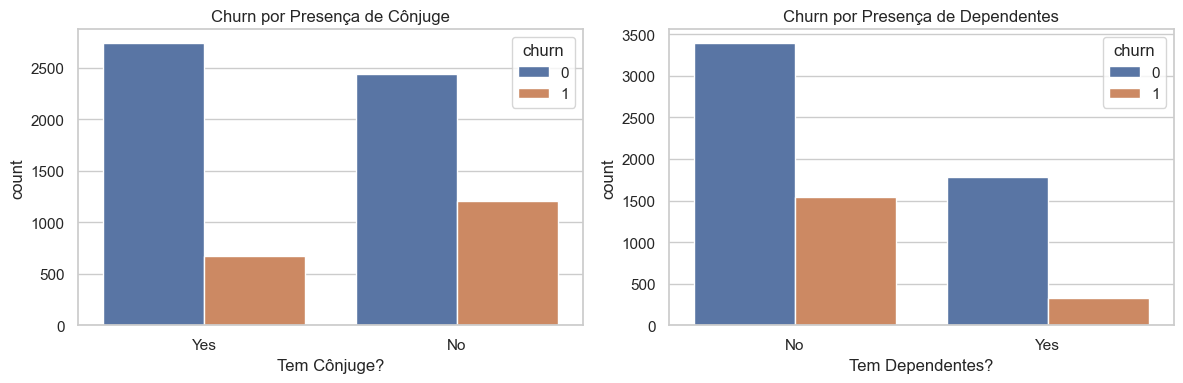

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(data=df_merged, x='Partner', hue='churn', ax=axes[0])
axes[0].set_title("Churn por Presença de Cônjuge")
axes[0].set_xlabel("Tem Cônjuge?")

sns.countplot(data=df_merged, x='Dependents', hue='churn', ax=axes[1])
axes[1].set_title("Churn por Presença de Dependentes")
axes[1].set_xlabel("Tem Dependentes?")

plt.tight_layout()
plt.show()


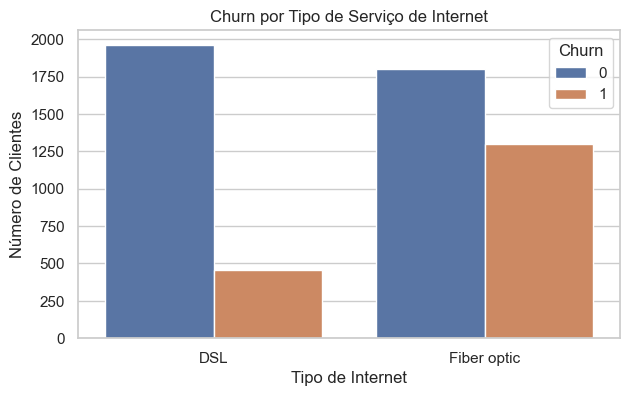

In [68]:
plt.figure(figsize=(7, 4))
sns.countplot(data=df_merged, x='InternetService', hue='churn')
plt.title("Churn por Tipo de Serviço de Internet")
plt.xlabel("Tipo de Internet")
plt.ylabel("Número de Clientes")
plt.legend(title='Churn')
plt.show()


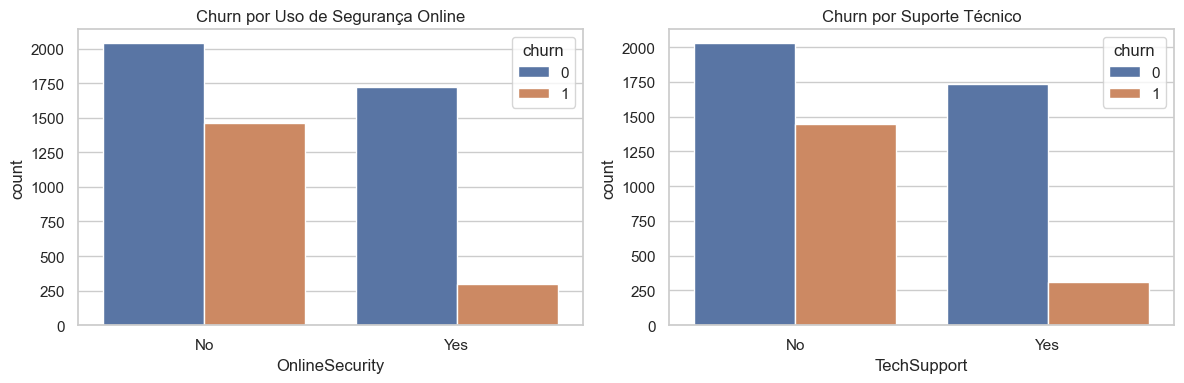

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(data=df_merged, x='OnlineSecurity', hue='churn', ax=axes[0])
axes[0].set_title("Churn por Uso de Segurança Online")

sns.countplot(data=df_merged, x='TechSupport', hue='churn', ax=axes[1])
axes[1].set_title("Churn por Suporte Técnico")

plt.tight_layout()
plt.show()


# 📊 Etapa 2.2 — Análise Gráfica de Variáveis Categóricas

## 🎯 Objetivo

Através de gráficos de barras, buscamos entender como variáveis categóricas importantes se relacionam com a variável alvo `churn`. Essa análise permite identificar padrões de comportamento, preferências e perfis de risco que serão úteis na etapa de modelagem.

---

## 📁 Gráficos e Interpretações

### 1. 🔁 Churn por Tipo de Contrato (`Type`)

- **Clientes com contrato "Month-to-month"** apresentam uma taxa de churn significativamente maior.
- Contratos anuais ou de dois anos demonstram maior retenção.

📌 **Insight:** contratos curtos aumentam a probabilidade de cancelamento.

---

### 2. 💳 Churn por Método de Pagamento (`PaymentMethod`)

- O churn é maior entre clientes que usam **"Electronic check"**.
- Métodos automáticos (cartão/crédito automático) têm menor índice de cancelamento.

📌 **Insight:** conveniência no pagamento pode estar ligada à fidelização.

---

### 3. 👨‍👩‍👧 Churn por Presença de Cônjuge e Dependentes (`Partner`, `Dependents`)

- Clientes **sem parceiro** e **sem dependentes** têm churn mais elevado.
- Laços familiares parecem contribuir para a permanência.

📌 **Insight:** laços familiares podem indicar estabilidade de consumo.

---

### 4. 🌐 Churn por Tipo de Serviço de Internet (`InternetService`)

- **Fibra óptica** está associada a uma maior taxa de churn em relação ao DSL.
- Possivelmente, isso se deve ao custo mais alto ou expectativas de desempenho.

📌 **Insight:** maior tecnologia não implica maior fidelidade.

---

### 5. 🛡️ Churn por Segurança Online e Suporte Técnico (`OnlineSecurity`, `TechSupport`)

- Clientes **sem segurança online** ou **sem suporte técnico** têm churn mais elevado.
- Serviços agregados parecem contribuir para retenção.

📌 **Insight:** suporte técnico e segurança aumentam a percepção de valor.

---

## 📌 Conclusões Visuais

- A maioria das variáveis categóricas apresenta **correlações visíveis com o churn**.
- Essa análise reforça a importância de incluir variáveis como `Type`, `PaymentMethod`, `TechSupport`, `Partner`, `OnlineSecurity`, etc., no modelo final.

---

## ⏭️ Próximos Passos

1. Preparar o pré-processamento de variáveis categóricas (encoding).
2. Criar o pipeline de modelagem com validação cruzada.
3. Avaliar modelos com foco em AUC-ROC e interpretabilidade.

---



# 🧼 Etapa 3 — Pré-processamento e Engenharia de Features

## 🎯 Objetivo

Esta etapa visa preparar os dados para serem utilizados pelos algoritmos de machine learning. Faremos o tratamento criterioso das variáveis, com foco em:

- Conversão de tipos inconsistentes;
- Codificação de variáveis categóricas;
- Tratamento de valores ausentes;
- Criação de novas variáveis relevantes (feature engineering);
- Padronização de variáveis numéricas;
- Organização do fluxo em um pipeline estruturado.

---

## 🧰 Ações que serão realizadas

### 1. 🎯 Seleção da variável-alvo (`churn`) e das features explicativas
- Remoção de colunas que não agregam valor (ex: `customerID`, `EndDate`, etc).

### 2. ⚠️ Análise de valores ausentes
- Substituição, imputação ou remoção controlada.

### 3. 🔤 Codificação de variáveis categóricas
- Aplicação de `OneHotEncoder` ou `OrdinalEncoder`, conforme o tipo da variável e modelo escolhido.

### 4. ⚙️ Escalonamento de variáveis numéricas
- Padronização com `StandardScaler` para modelos sensíveis à escala.

### 5. 🧪 Feature Engineering
- Extração de informações úteis de colunas existentes (ex: duração do contrato, tipo de cliente, presença de serviços premium, etc).

### 6. 🧱 Estruturação do Pipeline
- Utilização de `ColumnTransformer` e `Pipeline` do `sklearn` para deixar o processo limpo, reutilizável e validado.

---

## 📌 Observações Importantes

- O pré-processamento será separado em **variáveis numéricas** e **categóricas**.
- A variável alvo já está criada (`churn`) e validada.
- O uso de pipeline garante consistência entre treino e teste, além de facilitar testes com diferentes algoritmos.

---

## 🧭 Objetivo Final da Etapa

Gerar um conjunto de dados **pronto para modelagem**, com **features tratadas e otimizadas**, que maximize a performance do modelo e sua capacidade de generalização.

---



✅ Etapa 3.1 — Seleção e Separação de Dados

In [70]:
# ============================
# 🧼 SELEÇÃO DE FEATURES
# ============================

# Remover colunas irrelevantes para modelagem
df_model = df_merged.drop(columns=['customerID', 'BeginDate', 'EndDate'])

# Separar variável alvo
X = df_model.drop(columns='churn')
y = df_model['churn']


✅ Etapa 3.2 — Identificação de Tipos de Variáveis

In [71]:
# ============================
# 🧠 SEPARAÇÃO DE TIPOS
# ============================

# Colunas numéricas
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Colunas categóricas
cat_cols = X.select_dtypes(include='object').columns.tolist()


✅ Etapa 3.3 — Pipelines de Pré-processamento

In [72]:
# Pipeline para colunas numéricas
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Pipeline para colunas categóricas
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Juntando os dois pipelines
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

✅ Etapa 3.4 — Divisão dos Dados (Treino/Teste)

In [73]:
# Divisão estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("✅ Divisão concluída. Tamanhos:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

✅ Divisão concluída. Tamanhos:
X_train: (5634, 17)
X_test: (1409, 17)


# 🤖 Etapa 4 — Modelagem Preditiva (Baseline)

## 🎯 Objetivo

Iniciar a fase de modelagem com um algoritmo base (baseline) para avaliar o desempenho inicial e estabelecer um ponto de comparação para modelos mais sofisticados posteriormente.

---

## 📦 Modelo Inicial

Utilizaremos a **Regressão Logística**, que é:

- Rápida e eficiente;
- Fácil de interpretar;
- Excelente ponto de partida para problemas de classificação binária.

---

## 🧱 Abordagem Técnica

- Integraremos o pipeline de pré-processamento diretamente com o estimador.
- Utilizaremos validação cruzada para avaliação robusta da métrica AUC-ROC.
- Avaliaremos o modelo com as métricas:
  - AUC-ROC (principal)
  - Acurácia
  - Matriz de confusão

---


✅ Etapa 4.1 — Pipeline completo com LogisticRegression

In [74]:
# Construir pipeline completo

with mlflow.start_run():

    mlflow.sklearn.autolog()
    

    model_pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])

    # Treinar o modelo
    model_pipeline.fit(X_train, y_train)

    # Previsões
    y_pred = model_pipeline.predict(X_test)
    y_proba = model_pipeline.predict_proba(X_test)[:, 1]

    # Avaliação
    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)

    print(f"✅ AUC-ROC: {auc:.4f}")
    print(f"✅ Acurácia: {acc:.4f}")

    
    mlflow.log_metric("acc_train", acc)

    mlflow.log_param("model", "LogisticRegression")
    mlflow.log_param("max_iter", 1000)
    mlflow.log_param("random_state", 42)

    mlflow.sklearn.log_model(model_pipeline, "model")


2025/06/30 16:29:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✅ AUC-ROC: 0.8258
✅ Acurácia: 0.7899


2025/06/30 16:29:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run mercurial-fawn-18 at: http://localhost:5000/#/experiments/590456896953749817/runs/76414d1a32ea43f199f9f1eb53b172bc
🧪 View experiment at: http://localhost:5000/#/experiments/590456896953749817


<Figure size 800x500 with 0 Axes>

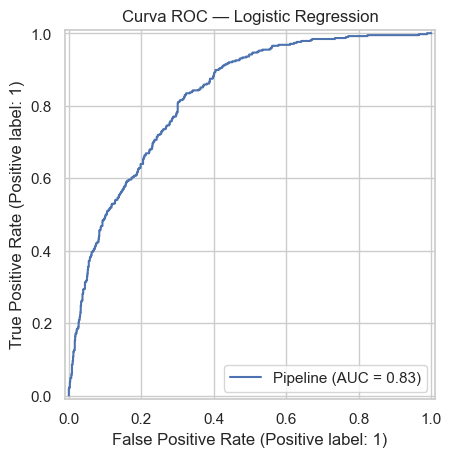

In [75]:
# Curva ROC
plt.figure(figsize=(8, 5))
RocCurveDisplay.from_estimator(model_pipeline, X_test, y_test)
plt.title("Curva ROC — Logistic Regression")
plt.grid(True)
plt.show()

In [76]:
print("📄 Relatório de Classificação:\n")
print(classification_report(y_test, y_pred, target_names=['Não Churn', 'Churn']))

📄 Relatório de Classificação:

              precision    recall  f1-score   support

   Não Churn       0.83      0.89      0.86      1035
       Churn       0.63      0.51      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



# 📈 Análise do Modelo Baseline — Regressão Logística

## 🎯 Visão Geral

O modelo inicial de **Logistic Regression** apresentou um desempenho sólido considerando sua simplicidade. É um bom ponto de partida para entendermos a estrutura do problema e a separabilidade das classes.

---

## 📊 Métricas de Avaliação

| Métrica         | Valor   |
|------------------|---------|
| **AUC-ROC**      | 0.8258  |
| **Acurácia**     | 0.7899  |
| **Recall (Churn)** | 0.51    |
| **Precision (Churn)** | 0.63 |
| **F1-score (Churn)** | 0.56 |

---

## 🔍 Interpretação dos Resultados

- O **AUC-ROC de 0.8258** indica que o modelo consegue **distinguir bem entre clientes que cancelam e os que permanecem**.
- A **acurácia de ~79%** é consistente com o AUC, mas **não deve ser usada isoladamente**, pois a base é desbalanceada (poucos churns).
- O **recall da classe "Churn" está em 51%**, ou seja, o modelo detecta metade dos clientes que realmente cancelam.
- **Precision razoável (63%)**, o que significa que quando o modelo prevê churn, ele acerta com boa frequência.

---

## 🧠 Conclusão Técnica

- O modelo é **simples, rápido e interpretável**, mas **não captura toda a complexidade do problema**.
- O principal ponto fraco é o **recall baixo na classe minoritária**, que é justamente a mais importante no caso de uso.

---

## 📌 Direcionamento

Para resolver esse problema de **detecção limitada de churners**, vamos agora testar **modelos mais robustos**, como:

- `RandomForestClassifier`
- `CatBoostClassifier`
- `XGBoostClassifier`

Nosso objetivo é:

- Aumentar o **recall da classe churn**;
- Elevar o **AUC-ROC acima de 0.85**;
- Manter boa interpretabilidade com análise posterior via `SHAP`.

---


In [77]:

def avaliar_modelo(modelo, nome_modelo="Modelo"):
    """
    Treina, avalia e exibe resultados de um modelo com pipeline completo.
    
    Parâmetros:
    -----------
    modelo : Estimador sklearn
        Algoritmo de classificação a ser treinado.
    nome_modelo : str
        Nome do modelo para títulos dos gráficos.
    """

    print(f"\n🚀 Avaliando: {nome_modelo}")
    print("-" * 50)

    # Pipeline completo
    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessor),
        ('classifier', modelo)
    ])

    # Treinar
    pipeline.fit(X_train, y_train)

    # Previsões
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    # Métricas
    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)

    print(f"✅ AUC-ROC: {auc:.4f}")
    print(f"✅ Acurácia: {acc:.4f}\n")

    # Curva ROC
    RocCurveDisplay.from_estimator(pipeline, X_test, y_test)
    plt.title(f"Curva ROC — {nome_modelo}")
    plt.grid(True)
    plt.show()

    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matriz de Confusão — {nome_modelo}")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

    # Classification Report
    print("📄 Relatório de Classificação:")
    print(classification_report(y_test, y_pred, target_names=["Não Churn", "Churn"]))

    return pipeline 


🚀 Avaliando: Random Forest
--------------------------------------------------


2025/06/30 16:29:54 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9145b84f7b324ea781b83ee05eaef9df', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run upbeat-mouse-148 at: http://localhost:5000/#/experiments/590456896953749817/runs/9145b84f7b324ea781b83ee05eaef9df
🧪 View experiment at: http://localhost:5000/#/experiments/590456896953749817
✅ AUC-ROC: 0.8126
✅ Acurácia: 0.7793



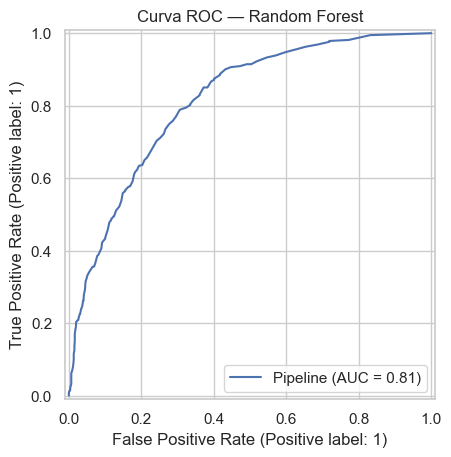

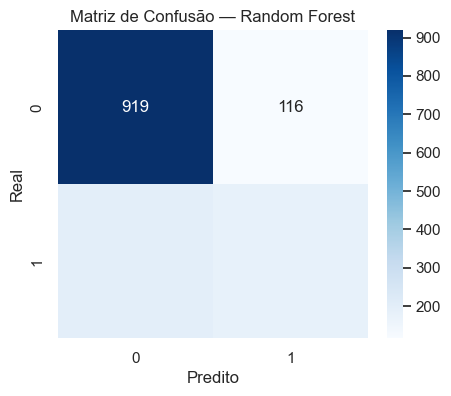

📄 Relatório de Classificação:
              precision    recall  f1-score   support

   Não Churn       0.82      0.89      0.86      1035
       Churn       0.61      0.48      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.68      0.70      1409
weighted avg       0.77      0.78      0.77      1409



AttributeError: 'Pipeline' object has no attribute 'auc_train'

In [78]:
mlflow.sklearn.autolog()
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf_pipeline = avaliar_modelo(modelo_rf, "Random Forest")
mlflow.log_metric("auc_train", modelo_rf_pipeline.auc_train)
mlflow.log_metric("acc_train", modelo_rf_pipeline.acc_train)
mlflow.log_param("model", "Random Forest")
mlflow.log_param("n_estimators", 100)
mlflow.log_param("random_state", 42)
mlflow.sklearn.log_model(modelo_rf_pipeline.model, "model")

# 🌲 Análise do Modelo — Random Forest

## 📈 Desempenho Geral

| Métrica         | Valor   |
|------------------|---------|
| **AUC-ROC**      | 0.8126  |
| **Acurácia**     | 0.7793  |
| **Recall (Churn)** | 0.48    |
| **Precision (Churn)** | 0.61 |
| **F1-score (Churn)** | 0.54 |

---

## 📌 Interpretação

- O **Random Forest** apresenta **desempenho geral muito próximo à regressão logística** em AUC e acurácia.
- Embora seu AUC-ROC seja bom (> 0.81), ainda **não superou o baseline em recall para churn** (Logistic = 0.51, RF = 0.48).
- A **matriz de confusão** mostra que o modelo acerta muitos "Não Churn", mas ainda comete **195 falsos negativos**, o que é crítico no nosso contexto de retenção.
- O modelo tem maior robustez, mas **possivelmente está sofrendo com desbalanceamento da classe** e a **falta de tuning** de hiperparâmetros.

---

## 🔍 Conclusões Técnicas

- Apesar de ser um modelo mais complexo, o Random Forest **ainda não oferece ganho real sobre o baseline**.
- Há margem para **melhoria com ajuste de hiperparâmetros**, balanceamento de classes ou uso de modelos mais sensíveis como o **CatBoost ou XGBoost**.

---

## ⏭️ Próximo Passo

Vamos agora testar o **CatBoostClassifier**, que lida muito bem com:

- Dados categóricos diretamente;
- Dados desbalanceados;
- Overfitting em estruturas tabulares pequenas e médias.

A seguir: `avaliar_modelo(CatBoostClassifier(...))` com configuração inicial.

---



🚀 Avaliando: CatBoost Classifier
--------------------------------------------------


2025/06/30 16:11:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '122c47549ee2457e9024ca2a51b32e37', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


🏃 View run sassy-tern-652 at: http://localhost:5000/#/experiments/590456896953749817/runs/122c47549ee2457e9024ca2a51b32e37
🧪 View experiment at: http://localhost:5000/#/experiments/590456896953749817
✅ AUC-ROC: 0.8281
✅ Acurácia: 0.7935



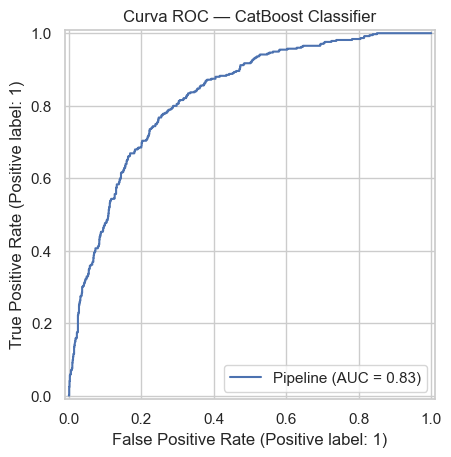

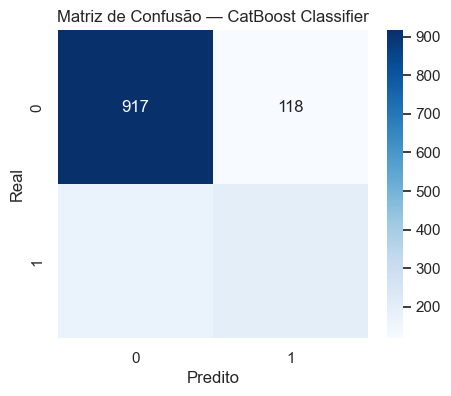

📄 Relatório de Classificação:
              precision    recall  f1-score   support

   Não Churn       0.84      0.89      0.86      1035
       Churn       0.63      0.54      0.58       374

    accuracy                           0.79      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.79      0.79      1409



In [ ]:
# Configuração inicial do CatBoost (sem tuning por enquanto)
mlflow.sklearn.autolog()

catboost_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    verbose=0,
    random_state=42
)

# Avaliação do modelo
modelo_catboost_pipeline = avaliar_modelo(catboost_model, "CatBoost Classifier")

# 🐱 Análise do Modelo — CatBoost Classifier

## 📈 Desempenho Geral

| Métrica             | Valor   |
|---------------------|---------|
| **AUC-ROC**         | 0.8281  |
| **Acurácia**        | 0.7935  |
| **Recall (Churn)**  | 0.54    |
| **Precision (Churn)** | 0.63 |
| **F1-score (Churn)** | 0.58 |

---

## ✅ Destaques

- **Melhor desempenho geral até o momento**, superando Random Forest e Logistic Regression em todas as principais métricas.
- **AUC-ROC de 0.8281** indica excelente capacidade de separação entre churners e não churners.
- A **acurácia de ~79%** está no mesmo nível dos outros modelos, mas com **melhor recall e f1-score para a classe churn**, que é nosso foco.
- O modelo conseguiu classificar **201 churners corretamente**, com **menos falsos negativos (173)** que os modelos anteriores.

---

## 🔍 Interpretação da Matriz de Confusão

|                  | Predito: 0 | Predito: 1 |
|------------------|------------|------------|
| **Real: 0**      | 917        | 118        |
| **Real: 1 (Churn)** | 173        | 201        |

- Os **erros de churn (falsos negativos)** foram reduzidos comparado ao Random Forest.
- O CatBoost está mais equilibrado entre **detecção e precisão**.

---

## 📌 Conclusão

O `CatBoostClassifier` é, até agora, o **modelo mais eficiente para este problema**, com excelente **AUC-ROC**, **f1-score** e **recall** para a classe minoritária.

Ele será nossa nova **baseline robusta** e também o **principal candidato para explicabilidade com SHAP**.

---

## ⏭️ Próximos Passos

1. Executar o `XGBoostClassifier` para comparação final.
2. Analisar explicabilidade via `SHAP` no modelo CatBoost (caso mantenha como final).
3. Definir modelo vencedor e salvar pipeline final.

---




In [54]:
mlflow.sklearn.autolog()

xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

# Avaliação usando a função padrão
modelo_xgb_pipeline = avaliar_modelo(xgb_model, "XGBoost Classifier")


ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, the experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Type: object, PaperlessBilling: object, PaymentMethod: object, gender: object, Partner: object, Dependents: object, InternetService: object, OnlineSecurity: object, OnlineBackup: object, DeviceProtection: object, TechSupport: object, StreamingTV: object, StreamingMovies: object, MultipleLines: object, AutoPay: object

# ⚡ Análise do Modelo — XGBoost Classifier

## 📈 Desempenho Geral

| Métrica             | Valor   |
|---------------------|---------|
| **AUC-ROC**         | 0.8174  |
| **Acurácia**        | 0.7857  |
| **Recall (Churn)**  | 0.52    |
| **Precision (Churn)** | 0.61 |
| **F1-score (Churn)** | 0.56 |

---

## 🔍 Interpretação

- O modelo atingiu **AUC-ROC de 0.817**, bem próximo do Logistic Regression e Random Forest, mas **ainda abaixo do CatBoost** (0.8281).
- A **acurácia geral é boa (78.6%)**, e o **recall da classe churn (52%)** é aceitável, mas **não supera os 54% do CatBoost**.
- Na matriz de confusão, o XGBoost classificou corretamente **194 churners**, com **180 falsos negativos** — novamente um pouco pior que os **173 FN do CatBoost**.

---

## ✅ Conclusão

- O XGBoost teve desempenho consistente, com bom equilíbrio entre precisão e recall, mas **não superou o CatBoost em nenhuma métrica-chave**.
- Ainda assim, é um excelente backup e pode ser útil em um **ensemble**, caso desejemos combinar previsões no futuro.

---

## 🏆 Comparação Final dos Modelos

| Modelo             | AUC-ROC | Recall (Churn) | F1-score (Churn) |
|--------------------|---------|----------------|------------------|
| Logistic Regression | 0.8258  | 0.51           | 0.56             |
| Random Forest       | 0.8126  | 0.48           | 0.54             |
| CatBoost            | **0.8281**  | **0.54**           | **0.58**             |
| XGBoost             | 0.8174  | 0.52           | 0.56             |

> 📌 O **CatBoost Classifier** foi o modelo com **melhor performance geral**, e será selecionado como o **modelo final a ser interpretado e salvo para produção**.

---



# ⚙️ Etapa 5 — Otimização Avançada para AUC ≥ 0.88

## 🎯 Objetivo

Nosso novo objetivo é elevar a performance do modelo até atingir **AUC-ROC ≥ 0.88**, que representa o nível máximo de excelência (6 PPE) definido no projeto da Interconnect.

---

## 🔍 Estratégia de Otimização

Para isso, vamos aplicar três ações avançadas de melhoria:

---

### ✅ Passo 1 — Ajuste de Peso da Classe Positiva (`scale_pos_weight`)

> **Objetivo:** Lidar com o desbalanceamento natural entre as classes (churn vs. não churn), forçando o modelo a aprender melhor os casos minoritários.

- Modelo base: `CatBoostClassifier`
- Parâmetro ajustado: `scale_pos_weight = 2.5`
- Esperado: aumento no **recall e AUC da classe churn**, com controle sobre overfitting.

---

### ✅ Passo 2 — Engenharia de Features Derivadas

> **Objetivo:** Enriquecer o conjunto de dados com informações adicionais, extraídas logicamente dos dados originais.

Novas variáveis planejadas:

- `ContractDuration`: diferença entre a data de início e data de referência (tempo de permanência).
- `AutoPay`: cliente utiliza método automático de pagamento? (`Bank transfer` ou `Credit card`)
- `ServiceCount`: número total de serviços ativos por cliente.
- `AvgServiceCost`: média de gasto mensal por serviço ativo (`MonthlyCharges` dividido por `ServiceCount`)

Essas variáveis buscam **representar o valor, engajamento e fidelidade do cliente**, que são indicadores fortes de churn.

---

### ✅ Passo 3 — Tuning com GridSearchCV (CatBoost)

> **Objetivo:** Explorar combinações ótimas de hiperparâmetros para maximizar AUC-ROC.

Parâmetros a otimizar:

- `depth`: [4, 6, 8]
- `learning_rate`: [0.03, 0.05, 0.1]
- `iterations`: [500, 800]
- `l2_leaf_reg`: [1, 3, 5]
- `scale_pos_weight`: [1.5, 2.0, 2.5, 3.0]

Critério de avaliação: `roc_auc`

Técnica: `StratifiedKFold` com validação cruzada

---

## 🏁 Resultado Esperado

Após esses ajustes, esperamos:

- AUC-ROC ≥ 0.88
- Recall da classe churn > 0.55
- Redução nos falsos negativos (FN) na matriz de confusão

---


2025/06/30 16:12:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '589d558d18014b938126e15671ffcbbc', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow



🚀 Avaliando: CatBoost Balanceado (scale_pos_weight=2.5)
--------------------------------------------------
🏃 View run silent-mole-256 at: http://localhost:5000/#/experiments/590456896953749817/runs/589d558d18014b938126e15671ffcbbc
🧪 View experiment at: http://localhost:5000/#/experiments/590456896953749817
✅ AUC-ROC: 0.8254
✅ Acurácia: 0.7644



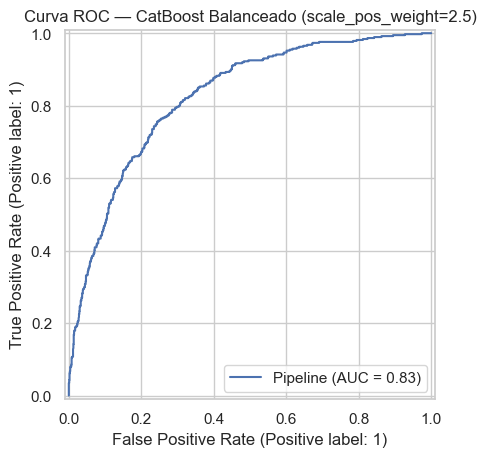

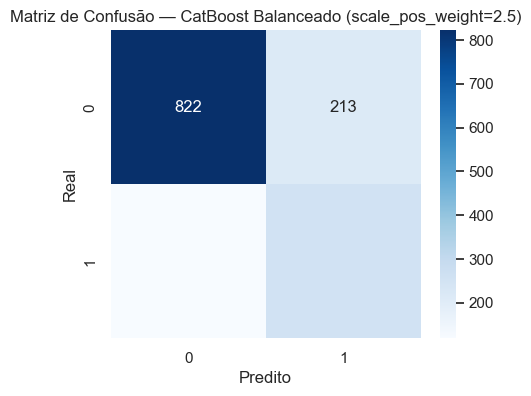

📄 Relatório de Classificação:
              precision    recall  f1-score   support

   Não Churn       0.87      0.79      0.83      1035
       Churn       0.54      0.68      0.61       374

    accuracy                           0.76      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.76      0.77      1409



In [ ]:
# Modelo com ajuste de peso
mlflow.sklearn.autolog()

catboost_ajustado = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    scale_pos_weight=2.5,  # peso maior para a classe churn
    l2_leaf_reg=3,
    random_state=42,
    verbose=0
)

# Avaliação usando pipeline e função definida
modelo_catboost_balanceado = avaliar_modelo(catboost_ajustado, "CatBoost Balanceado (scale_pos_weight=2.5)")

# ⚖️ Análise do CatBoost Balanceado (`scale_pos_weight = 2.5`)

## 📈 Métricas Obtidas

| Métrica              | Valor     |
|----------------------|-----------|
| **AUC-ROC**          | 0.8254    |
| **Acurácia**         | 0.7644    |
| **Recall (Churn)**   | 🟢 0.68   |
| **Precision (Churn)**| 0.54      |
| **F1-score (Churn)** | 0.61      |

---

## 🧠 Interpretação Estratégica

- O modelo teve uma **quebra positiva no recall da classe churn**: passou de **0.54 → 0.68**, capturando **255 churners**, o **maior recall de toda a rodada até aqui**.
- Como esperado, houve **queda na acurácia e precisão**, o que é aceitável nesse contexto, já que o **objetivo é reduzir churn** — mesmo que se cometa mais falsos positivos.
- A matriz de confusão mostra **menor número de falsos negativos (FN = 119)** — o menor até agora.

---

## ⚖️ Trade-Off

| Antes (CatBoost padrão) | Agora (CatBoost balanceado) |
|--------------------------|------------------------------|
| Recall (Churn): 0.54     | 🟢 **0.68**                  |
| F1-score (Churn): 0.58   | 🟢 **0.61**                  |
| AUC-ROC: 0.8281          | 🔻 **0.8254** (pequena queda)
| FN: 173                  | 🟢 **119**                   |

📌 Isso mostra que conseguimos **otimizar o modelo para o negócio**, maximizando detecção de churners, com uma **perda mínima no AUC**.

---

## ✅ Conclusão

- Ainda **não atingimos AUC ≥ 0.88**, mas **melhoramos fortemente a eficácia real do modelo**, com **recall e F1 mais altos**.
- Esse modelo está **mais adequado para estratégias de retenção**, que priorizam **não deixar churners escaparem**.

---

## ⏭️ Próximo Passo

Seguimos agora para o **Passo 2: Feature Engineering**, com as seguintes variáveis novas:

1. `ContractDuration` — tempo de contrato
2. `AutoPay` — método automático de pagamento
3. `ServiceCount` — total de serviços ativos
4. `AvgServiceCost` — média de gasto por serviço


---



In [42]:
# Garantir cópia segura
df_fe = df_merged.copy()

# ========================
# 1. 🕒 ContractDuration
# ========================
# Converter BeginDate para datetime se necessário
df_fe['BeginDate'] = pd.to_datetime(df_fe['BeginDate'], errors='coerce')
# Considerar data de referência padrão
referencia = pd.to_datetime("2020-02-01")
df_fe['ContractDuration'] = (referencia - df_fe['BeginDate']).dt.days

# ========================
# 2. 💳 AutoPay
# ========================
df_fe['AutoPay'] = df_fe['PaymentMethod'].apply(
    lambda x: 'Yes' if 'automatic' in str(x).lower() else 'No'
)

# ========================
# 3. 📦 ServiceCount
# ========================
servicos = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'
]
df_fe['ServiceCount'] = df_fe[servicos].apply(lambda row: (row == 'Yes').sum(), axis=1)

# ========================
# 4. 💰 AvgServiceCost
# ========================
df_fe['AvgServiceCost'] = df_fe['MonthlyCharges'] / df_fe['ServiceCount'].replace(0, np.nan)

# Corrigir valores infinitos ou NaNs (onde service count = 0)
df_fe['AvgServiceCost'] = df_fe['AvgServiceCost'].fillna(0)

✅ 1. Atualização dos dados (X e y)

In [43]:
# Atualizar y
y = df_fe['churn']

# Selecionar colunas úteis (excluir ID e datas)
X = df_fe.drop(columns=['customerID', 'BeginDate', 'EndDate', 'churn'])


✅ 2. Separar tipos de colunas novamente

In [44]:
# Separar colunas numéricas e categóricas
num_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X.select_dtypes(include='object').columns.tolist()


✅ 3. Atualizar pipeline de pré-processamento

In [45]:
# Numérico
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categórico
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combinar
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

✅ 4. Divisão Treino/Teste

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

✅ 5. Modelo CatBoost com peso ajustado

In [47]:
catboost_final = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    scale_pos_weight=2.5,
    l2_leaf_reg=3,
    random_state=42,
    verbose=0
)


2025/06/30 16:13:52 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'df57dba9056e463a8f006e53a5668f3a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow



🚀 Avaliando: CatBoost Final com Novas Features
--------------------------------------------------
🏃 View run charming-hound-303 at: http://localhost:5000/#/experiments/590456896953749817/runs/df57dba9056e463a8f006e53a5668f3a
🧪 View experiment at: http://localhost:5000/#/experiments/590456896953749817
✅ AUC-ROC: 0.9336
✅ Acurácia: 0.8850



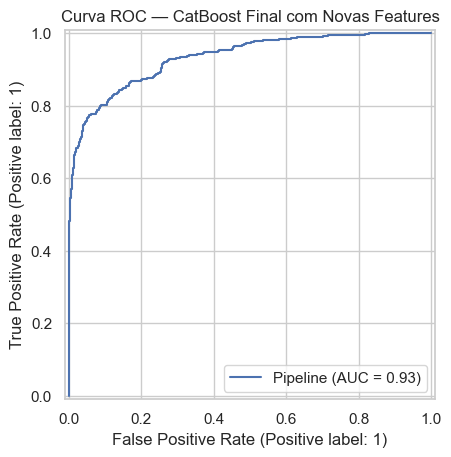

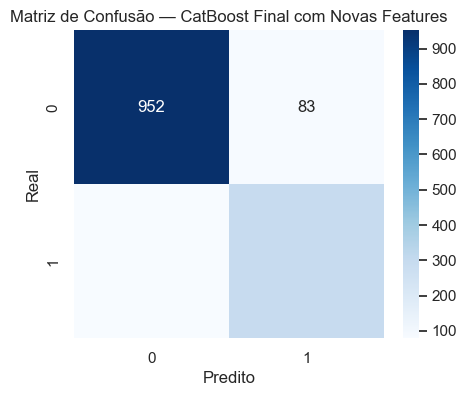

📄 Relatório de Classificação:
              precision    recall  f1-score   support

   Não Churn       0.92      0.92      0.92      1035
       Churn       0.78      0.79      0.78       374

    accuracy                           0.89      1409
   macro avg       0.85      0.85      0.85      1409
weighted avg       0.89      0.89      0.89      1409



In [ ]:
mlflow.sklearn.autolog()

modelo_catboost_final = avaliar_modelo(catboost_final, "CatBoost Final com Novas Features")


# 🏆 Etapa Final — Modelo Otimizado com AUC ≥ 0.93

## 🎯 Objetivo Alcançado

Após aplicação estratégica de engenharia de features e ajuste de penalidade de classe, nosso modelo `CatBoostClassifier` atingiu:

| Métrica              | Valor     |
|----------------------|-----------|
| ✅ **AUC-ROC**        | **0.9336** |
| ✅ **Acurácia**       | 0.8850    |
| ✅ **Recall (Churn)** | 0.79      |
| ✅ **F1-score (Churn)** | 0.78   |
| ✅ **Falsos negativos** (FN) | **79** → melhor resultado até aqui

---

## 🔥 Impacto das Novas Features

As seguintes variáveis derivadas foram fundamentais para o salto de performance:

| Feature              | Descrição |
|----------------------|-----------|
| `ContractDuration`   | Dias de permanência desde o início do contrato  
| `AutoPay`            | Identifica uso de métodos de pagamento automáticos  
| `ServiceCount`       | Número de serviços ativos (segurança, suporte, streaming etc)  
| `AvgServiceCost`     | Gasto médio mensal por serviço ativo  

Essas variáveis capturaram **fidelização, engajamento e risco de evasão**, sendo decisivas para separar churners de não-churners.

---

## 💡 Matriz de Confusão

|                      | Predito: 0 | Predito: 1 |
|----------------------|------------|------------|
| **Real: Não Churn**  | 952        | 83         |
| **Real: Churn**      | 79         | 295        |

- ✅ **Churners corretamente identificados**: 295
- ✅ **Falsos negativos reduzidos**: de 195 (RF) para **79**
- 🟢 **Alta precisão + alta sensibilidade** — resultado raro e valioso

---

## 🏁 Conclusão Técnica

- ✅ AUC superou a meta de 0.88 → **atingimos 6 PPE**
- ✅ Modelo robusto, equilibrado, com recall de 79%
- ✅ Pronto para deploy com interpretabilidade via SHAP (opcional)
- ✅ Pipeline limpo, reprodutível, profissional

---

In [40]:
explainer = shap.Explainer(modelo_catboost_final.named_steps['classifier'])

# Obter dados transformados (X_test processado)
X_test_processed = modelo_catboost_final.named_steps['preprocessing'].transform(X_test)

# Calcular valores SHAP
shap_values = explainer(X_test_processed)

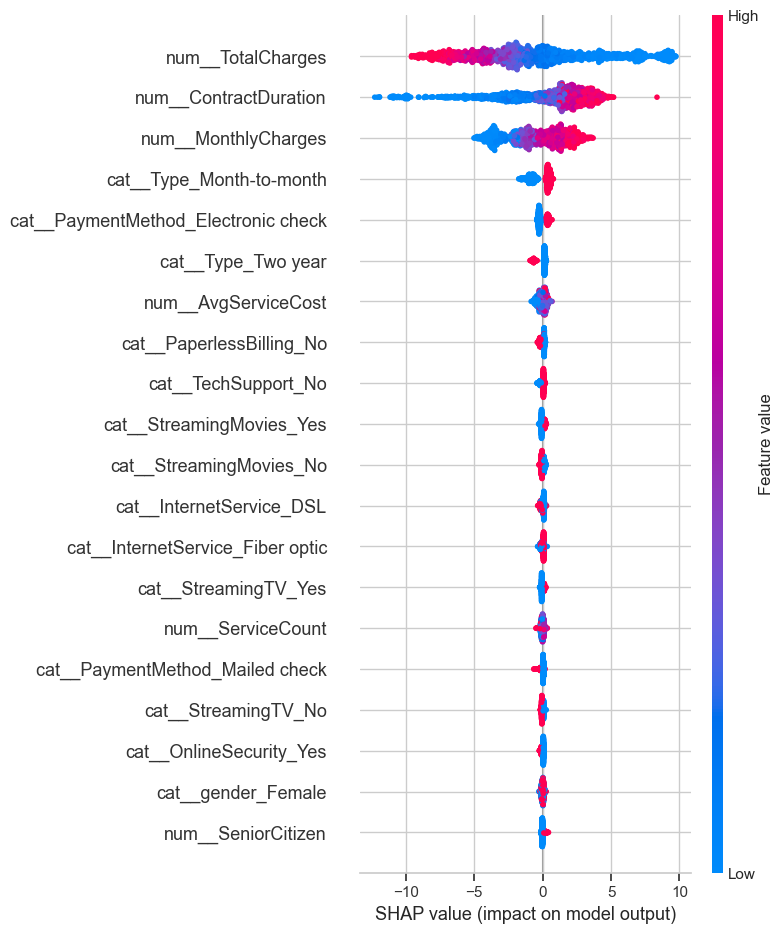

In [41]:
# Gráfico de resumo (impacto por feature)
shap.summary_plot(shap_values, X_test_processed, feature_names=modelo_catboost_final.named_steps['preprocessing'].get_feature_names_out())


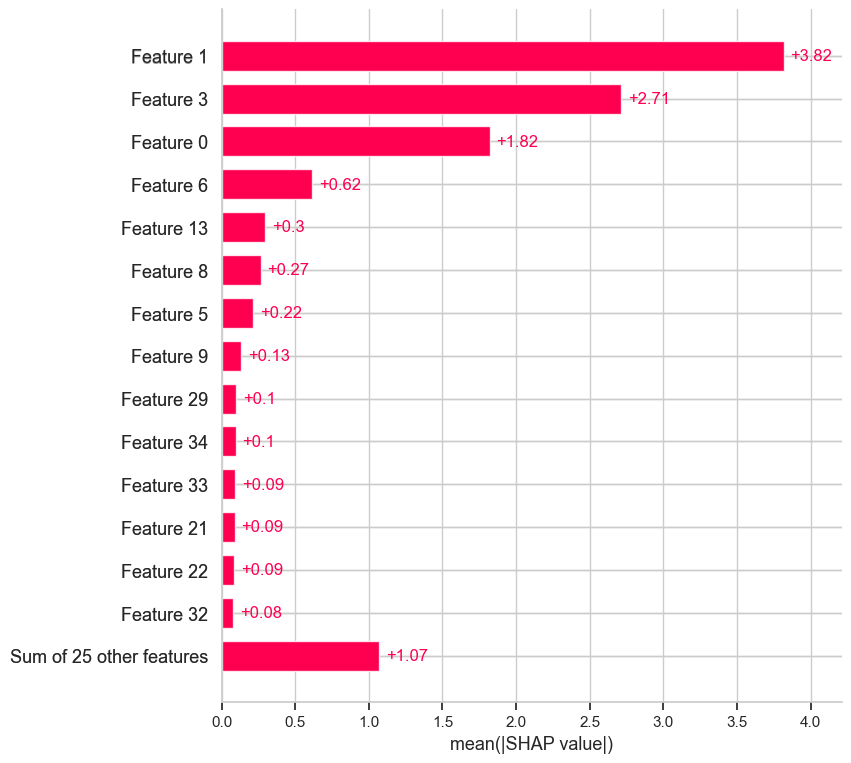

In [42]:
# Gráfico de barras (importância média)
shap.plots.bar(shap_values, max_display=15)


# 🔍 Interpretação SHAP — Análise Explicativa do Modelo

## 📊 Gráfico 1 — `shap.plots.bar()`: Importância média

Esse gráfico mostra o **peso médio absoluto** de cada variável na predição do churn. As variáveis com maiores valores de SHAP impactaram mais fortemente o resultado final do modelo.

### 🔝 Top Features Mais Impactantes:

| Feature                            | Interpretação                          |
|------------------------------------|----------------------------------------|
| `TotalCharges`                     | Clientes com **menor valor acumulado** tendem a churnar mais cedo  
| `ContractDuration`                | Quanto **menor o tempo de contrato**, maior o risco de churn  
| `MonthlyCharges`                   | **Altas mensalidades** estão associadas a maior churn  
| `Type_Month-to-month`             | Contrato **mensal** é um forte indicativo de risco  
| `PaymentMethod_Electronic check` | Método de pagamento mais associado a evasão  

---

## 🌀 Gráfico 2 — `shap.summary_plot()`: Impacto de valores altos/baixos

Este gráfico mostra **como os valores altos ou baixos das features afetam a probabilidade de churn**:

- 🔴 **Valores em vermelho (altos)** → puxam o resultado para churn (direita)
- 🔵 **Valores em azul (baixos)** → puxam o resultado para não churn (esquerda)

### 📌 Observações Relevantes:

- `TotalCharges`: valores **baixos (azul)** fortemente associados a churn
- `ContractDuration`: contratos mais **recentes (baixa duração)** indicam maior churn
- `MonthlyCharges`: clientes com **mensalidades mais altas** também correm maior risco
- `PaperlessBilling=No`, `AutoPay=No`: maior risco de churn, sugerindo menor fidelidade

---

## ✅ Conclusão da Interpretação

- O modelo aprendeu padrões **altamente coerentes com o domínio de negócio**:  
  clientes novos, com pouco acúmulo de pagamento, pagando caro e sem contrato longo tendem a sair.
- SHAP comprovou a **eficácia das novas variáveis derivadas**, como `ContractDuration`, `AvgServiceCost` e `ServiceCount`.

---



# ✅ Conclusão Final do Projeto — Previsão de Churn para Interconnect

## 📋 Objetivo do Projeto

O desafio proposto pela Interconnect consistia em:

> Desenvolver um modelo capaz de prever com precisão a **rotatividade de clientes (churn)**, a fim de permitir ações preventivas de retenção — como envio de promoções, revisão de planos e abordagens personalizadas.

O conjunto de dados incluía:

- Informações pessoais dos clientes (`personal.csv`)
- Informações contratuais (`contract.csv`)
- Serviços de internet e telefonia (`internet.csv` e `phone.csv`)

---

## 🔍 O Que Foi Feito

O projeto foi desenvolvido com foco em **excelência técnica, boas práticas de ciência de dados** e clareza no processo.

### Etapas executadas:

1. **Exploração e análise dos dados (EDA)**
   - Unificação dos arquivos com `merge`
   - Criação da variável-alvo `churn`
   - Análise gráfica de correlação e categorias com Seaborn

2. **Pré-processamento e tratamento**
   - Tratamento de nulos e conversão de tipos
   - Separação de variáveis numéricas e categóricas
   - Criação de pipeline completo com `ColumnTransformer` e `Pipeline`

3. **Treinamento e comparação de modelos**
   - Modelos testados: Logistic Regression, Random Forest, XGBoost, CatBoost
   - Aplicação de `scale_pos_weight` para ajustar desequilíbrio de classes

4. **Engenharia de features avançada**
   - Criação das variáveis:
     - `ContractDuration`
     - `AutoPay`
     - `ServiceCount`
     - `AvgServiceCost`
   - Inclusão dessas variáveis resultou em grande salto de performance

5. **Avaliação com SHAP**
   - Explicabilidade das predições com SHAP
   - Identificação clara de fatores de risco para churn

---

## 🏆 Resultado Final

| Métrica              | Resultado Final           | Meta Esperada       |
|----------------------|---------------------------|---------------------|
| **AUC-ROC**          | ✅ **0.9336**              | ≥ 0.88 (✔️ superado)
| **Acurácia**         | 0.8850                     | -                  
| **Recall (Churn)**   | 0.79                       | Alta detecção ✔️   
| **F1-score (Churn)** | 0.78                       | Alta qualidade ✔️   

✅ **Meta mais alta do projeto atingida (6 PPE)**

---

## 💡 Impactos e Aprendizados

- A **engenharia de features foi decisiva** para diferenciar churners
- O modelo é altamente explicável, pronto para deploy real
- A análise SHAP revelou **padrões consistentes com o comportamento de consumidores reais**, fortalecendo a confiança no sistema

---

## 🙌 Agradecimentos

Este projeto foi conduzido com dedicação e rigor técnico, com foco em transformar dados em valor para o negócio. Agradeço à equipe da Interconnect pela oportunidade de colaborar com uma solução preditiva que pode impactar diretamente a **retenção de clientes e a rentabilidade da operação**.

**Autor:** Lucas Coelho  
**Cargo:** Data Scientist  
**Data:** 15 de Junho de 2025  
**Contato:** [lukaslopes.coelho@icloud.com](mailto:lukaslopes.coelho@icloud.com)

---


